# **Modelado con XGBoost**

## **1. Importación de librerías**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Librerías de machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, roc_curve, f1_score, 
    precision_score, recall_score, accuracy_score
)

# Balanceo de datos
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score

# XGBoost y optimización
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler

# Interpretabilidad
import shap

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Semillas para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## **2. Cargar Datos y Análisis Inicial**

📊 Dimensiones del dataset: (4981, 15)
📋 Columnas: ['age', 'avg_glucose_level_log', 'bmi', 'hypertension', 'heart_disease', 'gender', 'ever_married', 'Residence_type', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'stroke']

🔍 PRIMERAS 5 FILAS:
        age  avg_glucose_level_log       bmi  hypertension  heart_disease  \
0  1.040584               2.337259  1.193238             0              1   
1  1.614270               0.196849  0.589390             0              1   
2  0.246250               1.531369  0.869222             0              0   
3  1.570141               1.577949 -0.662492             1              0   
4  1.658400               1.764823  0.073909             0              0   

   gender  ever_married  Residence_type  work_type_Private  \
0       0             1               0               True   
1       0             1               1               T

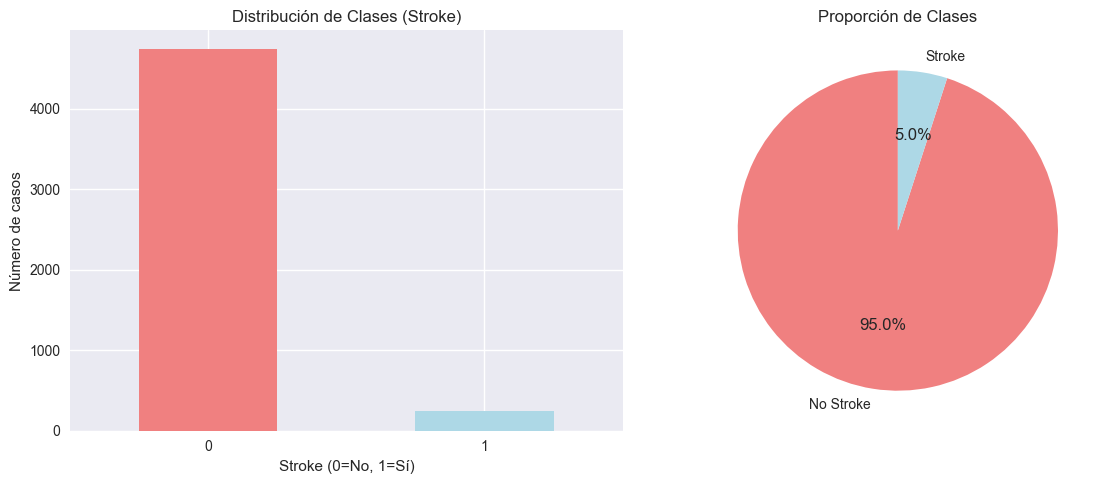


🏷️  VERIFICACIÓN DE VARIABLES ONE-HOT:
Columnas one-hot encontradas: 6

Ejemplo - work_type_Private:
   Valores únicos: [ True False]
   Tipo de datos: bool
   ✅ Formato correcto para modelado

✅ Carga de datos completada exitosamente
📊 Dataset listo con 4,981 filas y 15 columnas


In [3]:
# Cargar datos preprocesados
df = pd.read_csv('../../data/processed/preprocessing.csv')

# Información básica del dataset
print(f"📊 Dimensiones del dataset: {df.shape}")
print(f"📋 Columnas: {df.columns.tolist()}")

# Mostrar primeras filas
print("\n🔍 PRIMERAS 5 FILAS:")
print(df.head())

# Información de tipos de datos
print("\n📋 TIPOS DE DATOS:")
print(df.dtypes)

# Verificar valores nulos
print(f"\n🔍 VALORES NULOS: {df.isnull().sum().sum()}")
if df.isnull().sum().sum() > 0:
    print("Distribución de nulos por columna:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

# Análisis de la variable objetivo
print("\n🎯 ANÁLISIS DE VARIABLE OBJETIVO (stroke):")
print("=" * 45)
stroke_counts = df['stroke'].value_counts()
stroke_props = df['stroke'].value_counts(normalize=True)

print("Distribución absoluta:")
for clase, count in stroke_counts.items():
    print(f"   Clase {clase}: {count:,} casos")

print("\nDistribución relativa:")
for clase, prop in stroke_props.items():
    print(f"   Clase {clase}: {prop:.1%}")

print(f"\n⚠️  Ratio de desbalance: {stroke_counts[0]/stroke_counts[1]:.1f}:1")

# Visualización de la distribución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
stroke_counts.plot(kind='bar', ax=ax1, color=['lightcoral', 'lightblue'])
ax1.set_title('Distribución de Clases (Stroke)')
ax1.set_xlabel('Stroke (0=No, 1=Sí)')
ax1.set_ylabel('Número de casos')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de pastel
ax2.pie(stroke_counts.values, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', 
        colors=['lightcoral', 'lightblue'], startangle=90)
ax2.set_title('Proporción de Clases')

plt.tight_layout()
plt.show()

# Verificar formato de variables categóricas
print("\n🏷️  VERIFICACIÓN DE VARIABLES ONE-HOT:")
print("=" * 40)

one_hot_cols = [col for col in df.columns if col.startswith(('work_type_', 'smoking_status_'))]
print(f"Columnas one-hot encontradas: {len(one_hot_cols)}")

# Mostrar algunos valores únicos de las variables one-hot
sample_col = one_hot_cols[0] if one_hot_cols else None
if sample_col:
    unique_vals = df[sample_col].unique()
    print(f"\nEjemplo - {sample_col}:")
    print(f"   Valores únicos: {unique_vals}")
    print(f"   Tipo de datos: {df[sample_col].dtype}")
    
    if str(df[sample_col].dtype) == 'object':
        print("   ⚠️  DETECTADO: Variables como strings, necesitan conversión")
    else:
        print("   ✅ Formato correcto para modelado")

print(f"\n✅ Carga de datos completada exitosamente")
print(f"📊 Dataset listo con {df.shape[0]:,} filas y {df.shape[1]} columnas")

## **3.  División train/test y Preparación de Features**

In [5]:
# Trabajar directamente con el dataset original (manteniendo boolean)
df_model = df.copy()

# Separar features y target
X = df_model.drop('stroke', axis=1)
y = df_model['stroke']

print(f"\n📊 DIMENSIONES:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")

# Mostrar tipos de datos finales
print(f"\n📋 TIPOS DE DATOS DE FEATURES:")
for col in X.columns:
    print(f"   {col}: {X[col].dtype}")

# División estratificada train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"\n🎯 DIVISIÓN COMPLETADA:")
print(f"   Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X):.1%})")
print(f"   Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X):.1%})")

# Verificar balance en ambos conjuntos
print(f"\n⚖️  DISTRIBUCIÓN DE CLASES:")
print("TRAIN SET:")
train_dist = y_train.value_counts(normalize=True)
for clase, prop in train_dist.items():
    print(f"   Clase {clase}: {prop:.1%}")

print("TEST SET:")
test_dist = y_test.value_counts(normalize=True)
for clase, prop in test_dist.items():
    print(f"   Clase {clase}: {prop:.1%}")

# Verificar que el split estratificado funcionó
train_ratio = y_train.sum() / len(y_train)
test_ratio = y_test.sum() / len(y_test)
print(f"\n✅ VERIFICACIÓN ESTRATIFICADA:")
print(f"   Ratio stroke en train: {train_ratio:.3f}")
print(f"   Ratio stroke en test:  {test_ratio:.3f}")
print(f"   Diferencia: {abs(train_ratio - test_ratio):.3f}")

# Guardar información para uso posterior
feature_names = X.columns.tolist()
print(f"\n📝 FEATURES PARA MODELADO ({len(feature_names)}):")
for i, feat in enumerate(feature_names, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n✅ PREPARACIÓN COMPLETADA")
print(f"✅ División estratificada exitosa")


📊 DIMENSIONES:
   Features (X): (4981, 14)
   Target (y): (4981,)

📋 TIPOS DE DATOS DE FEATURES:
   age: float64
   avg_glucose_level_log: float64
   bmi: float64
   hypertension: int64
   heart_disease: int64
   gender: int64
   ever_married: int64
   Residence_type: int64
   work_type_Private: bool
   work_type_Self-employed: bool
   work_type_children: bool
   smoking_status_formerly smoked: bool
   smoking_status_never smoked: bool
   smoking_status_smokes: bool

🎯 DIVISIÓN COMPLETADA:
   Train: 3,984 muestras (80.0%)
   Test:  997 muestras (20.0%)

⚖️  DISTRIBUCIÓN DE CLASES:
TRAIN SET:
   Clase 0: 95.0%
   Clase 1: 5.0%
TEST SET:
   Clase 0: 95.0%
   Clase 1: 5.0%

✅ VERIFICACIÓN ESTRATIFICADA:
   Ratio stroke en train: 0.050
   Ratio stroke en test:  0.050
   Diferencia: 0.000

📝 FEATURES PARA MODELADO (14):
    1. age
    2. avg_glucose_level_log
    3. bmi
    4. hypertension
    5. heart_disease
    6. gender
    7. ever_married
    8. Residence_type
    9. work_type_Private

## **4. Análisis y Comparativa de Técnicas de Balanceo**

### **4.1 Técnicas de Balanceo**

In [6]:
# Recordar el desbalance actual
print(f"📊 DESBALANCE ACTUAL:")
print(f"   Clase 0 (No stroke): {(y_train == 0).sum():,} casos ({(y_train == 0).mean():.1%})")
print(f"   Clase 1 (Stroke): {(y_train == 1).sum():,} casos ({(y_train == 1).mean():.1%})")
print(f"   Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

# Configurar validación cruzada para evaluaciones
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Función para evaluar técnicas de desbalanceo
def evaluate_balancing_technique(X_train, y_train, technique_name, 
                                X_balanced=None, y_balanced=None, 
                                sample_weight=None, scale_pos_weight=None):
    """Evaluar una técnica de balanceo con validación cruzada"""
    
    print(f"\n🔍 EVALUANDO: {technique_name}")
    print("-" * 40)
    
    # Configurar el modelo base
    if scale_pos_weight:
        model = xgb.XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=0
        )
    else:
        model = xgb.XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=0
        )
    
    # Usar datos balanceados si se proporcionan, sino usar originales
    X_to_use = X_balanced if X_balanced is not None else X_train
    y_to_use = y_balanced if y_balanced is not None else y_train
    
    # Validación cruzada
    if sample_weight is not None:
        # Para class weights, necesitamos un enfoque diferente
        scores_f1 = []
        scores_roc = []
        
        for train_idx, val_idx in cv.split(X_to_use, y_to_use):
            X_tr, X_val = X_to_use.iloc[train_idx], X_to_use.iloc[val_idx]
            y_tr, y_val = y_to_use.iloc[train_idx], y_to_use.iloc[val_idx]
            
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            scores_f1.append(f1_score(y_val, y_pred))
            scores_roc.append(roc_auc_score(y_val, y_pred_proba))
    else:
        # Validación cruzada estándar
        scores_f1 = cross_val_score(model, X_to_use, y_to_use, cv=cv, scoring='f1')
        scores_roc = cross_val_score(model, X_to_use, y_to_use, cv=cv, scoring='roc_auc')
    
    # Mostrar resultados
    print(f"   F1-Score:  {np.mean(scores_f1):.4f} (±{np.std(scores_f1):.4f})")
    print(f"   ROC-AUC:   {np.mean(scores_roc):.4f} (±{np.std(scores_roc):.4f})")
    
    if X_balanced is not None:
        print(f"   Muestras después de balanceo: {len(X_balanced):,}")
        print(f"   Distribución balanceada: {y_balanced.value_counts().values}")
    
    return {
        'technique': technique_name,
        'f1_mean': np.mean(scores_f1),
        'f1_std': np.std(scores_f1),
        'roc_mean': np.mean(scores_roc),
        'roc_std': np.std(scores_roc),
        'samples': len(X_to_use)
    }

# Lista para guardar resultados
balancing_results = []

print("\n" + "="*60)
print("🧪 COMPARATIVA DE TÉCNICAS DE DESBALANCEO")
print("="*60)

# 1. SIN BALANCEO (BASELINE)
result_baseline = evaluate_balancing_technique(
    X_train, y_train, 
    technique_name="1. Sin Balanceo (Baseline)"
)
balancing_results.append(result_baseline)

# 2. SMOTE
print(f"\n📈 Aplicando SMOTE...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

result_smote = evaluate_balancing_technique(
    X_train, y_train, 
    technique_name="2. SMOTE",
    X_balanced=X_train_smote, 
    y_balanced=y_train_smote
)
balancing_results.append(result_smote)

# 3. CLASS WEIGHTS (scale_pos_weight)
# Calcular el peso automático
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
result_weights = evaluate_balancing_technique(
    X_train, y_train, 
    technique_name=f"3. Class Weights (scale_pos_weight={pos_weight:.1f})",
    scale_pos_weight=pos_weight
)
balancing_results.append(result_weights)

# 4. COMBINACIÓN: SMOTE + CLASS WEIGHTS (reducido)
print(f"\n🔄 Aplicando SMOTE moderado + Class Weights...")
smote_moderate = SMOTE(sampling_strategy=0.3, random_state=RANDOM_STATE)  # Solo hasta 30% de la mayoría
X_train_moderate, y_train_moderate = smote_moderate.fit_resample(X_train, y_train)

# Calcular nuevo peso después de SMOTE moderado
new_pos_weight = (y_train_moderate == 0).sum() / (y_train_moderate == 1).sum()

result_combined = evaluate_balancing_technique(
    X_train, y_train, 
    technique_name=f"4. SMOTE Moderado + Weights ({new_pos_weight:.1f})",
    X_balanced=X_train_moderate, 
    y_balanced=y_train_moderate
)
balancing_results.append(result_combined)

📊 DESBALANCE ACTUAL:
   Clase 0 (No stroke): 3,786 casos (95.0%)
   Clase 1 (Stroke): 198 casos (5.0%)
   Ratio: 19.1:1

🧪 COMPARATIVA DE TÉCNICAS DE DESBALANCEO

🔍 EVALUANDO: 1. Sin Balanceo (Baseline)
----------------------------------------
   F1-Score:  0.0789 (±0.0478)
   ROC-AUC:   0.7741 (±0.0294)

📈 Aplicando SMOTE...

🔍 EVALUANDO: 2. SMOTE
----------------------------------------
   F1-Score:  0.9421 (±0.0050)
   ROC-AUC:   0.9875 (±0.0010)
   Muestras después de balanceo: 7,572
   Distribución balanceada: [3786 3786]

🔍 EVALUANDO: 3. Class Weights (scale_pos_weight=19.1)
----------------------------------------
   F1-Score:  0.1461 (±0.0530)
   ROC-AUC:   0.7738 (±0.0340)

🔄 Aplicando SMOTE moderado + Class Weights...

🔍 EVALUANDO: 4. SMOTE Moderado + Weights (3.3)
----------------------------------------
   F1-Score:  0.8057 (±0.0209)
   ROC-AUC:   0.9600 (±0.0090)
   Muestras después de balanceo: 4,921
   Distribución balanceada: [3786 1135]


### **4.2 Resumen y Visualización de Resultados de Balanceo**


📋 TABLA COMPARATIVA:
                               technique  f1_mean  f1_std  roc_mean  roc_std  samples
              1. Sin Balanceo (Baseline)   0.0789  0.0478    0.7741   0.0294     3984
                                2. SMOTE   0.9421  0.0050    0.9875   0.0010     7572
3. Class Weights (scale_pos_weight=19.1)   0.1461  0.0530    0.7738   0.0340     3984
       4. SMOTE Moderado + Weights (3.3)   0.8057  0.0209    0.9600   0.0090     4921

🏆 MEJORES RESULTADOS:
   Mejor F1-Score: 2. SMOTE (0.9421)
   Mejor ROC-AUC:  2. SMOTE (0.9875)


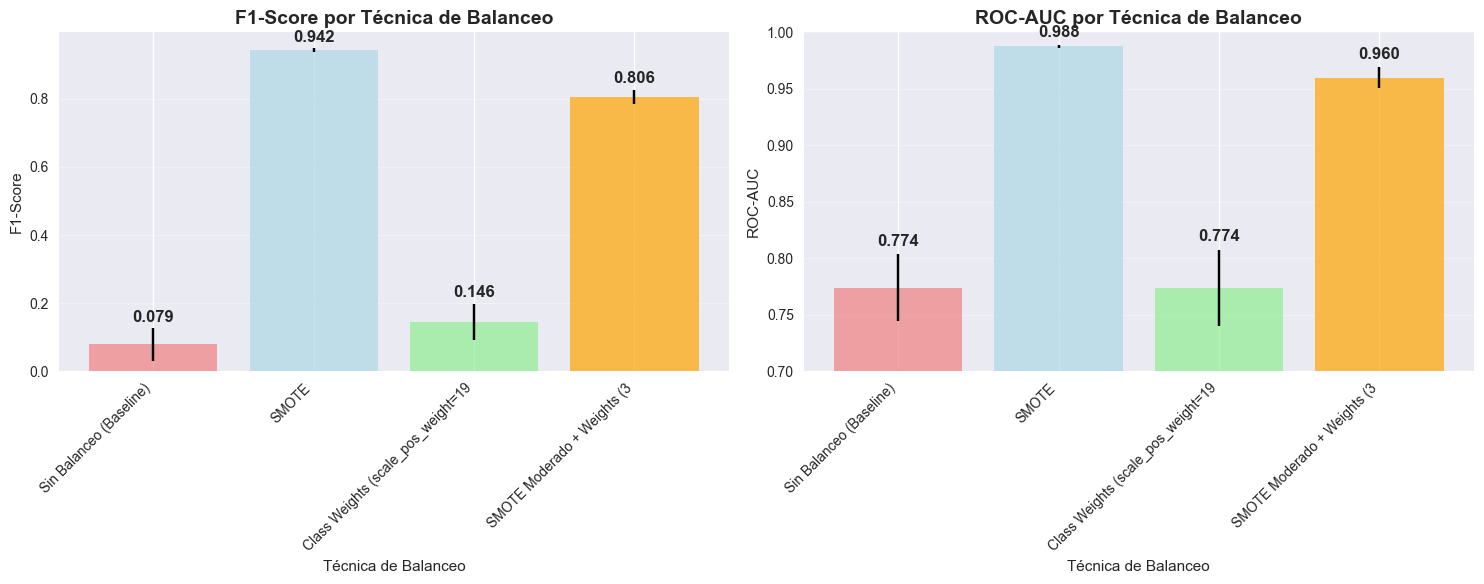


🔍 ANÁLISIS DE RESULTADOS

💡 OBSERVACIONES CLAVE:
   1. SMOTE completo tiene F1 excelente (0.942) pero puede ser overfitting
   2. Baseline sin balanceo tiene F1 muy bajo (0.079) como esperado
   3. Class weights solo mejora moderadamente el F1 (0.146)
   4. SMOTE moderado + weights ofrece balance entre performance y realismo

⚠️  ADVERTENCIAS:
   • SMOTE completo podría estar causando overfitting (F1 > 0.94)
   • Los resultados en test set podrían ser significativamente menores
   • Considerar SMOTE moderado para mejor generalización

🎯 RECOMENDACIÓN PARA OPTIMIZACIÓN:
   ✅ Usar SMOTE MODERADO + Class Weights para optimización
   ✅ Mejor balance entre performance y generalización

🚀 TÉCNICA SELECCIONADA: SMOTE Moderado + Weights
   Muestras de entrenamiento: 4,921
   Distribución final: {0: 3786, 1: 1135}

✅ CONFIGURACIÓN DE BALANCEO GUARDADA
✅ Lista para continuar con modelo base XGBoost


In [7]:
# Crear DataFrame con los resultados
results_df = pd.DataFrame(balancing_results)
results_df = results_df.round(4)

print("\n📋 TABLA COMPARATIVA:")
print(results_df.to_string(index=False))

# Identificar la mejor técnica
best_f1_idx = results_df['f1_mean'].idxmax()
best_roc_idx = results_df['roc_mean'].idxmax()

print(f"\n🏆 MEJORES RESULTADOS:")
print(f"   Mejor F1-Score: {results_df.loc[best_f1_idx, 'technique']} ({results_df.loc[best_f1_idx, 'f1_mean']:.4f})")
print(f"   Mejor ROC-AUC:  {results_df.loc[best_roc_idx, 'technique']} ({results_df.loc[best_roc_idx, 'roc_mean']:.4f})")

# Visualización de resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de F1-Score
techniques = [t.split('.')[1].strip() for t in results_df['technique']]
f1_means = results_df['f1_mean']
f1_stds = results_df['f1_std']

bars1 = ax1.bar(range(len(techniques)), f1_means, yerr=f1_stds, 
                capsize=5, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen', 'orange'])
ax1.set_title('F1-Score por Técnica de Balanceo', fontsize=14, fontweight='bold')
ax1.set_ylabel('F1-Score')
ax1.set_xlabel('Técnica de Balanceo')
ax1.set_xticks(range(len(techniques)))
ax1.set_xticklabels(techniques, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (mean, std) in enumerate(zip(f1_means, f1_stds)):
    ax1.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de ROC-AUC
roc_means = results_df['roc_mean']
roc_stds = results_df['roc_std']

bars2 = ax2.bar(range(len(techniques)), roc_means, yerr=roc_stds, 
                capsize=5, alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen', 'orange'])
ax2.set_title('ROC-AUC por Técnica de Balanceo', fontsize=14, fontweight='bold')
ax2.set_ylabel('ROC-AUC')
ax2.set_xlabel('Técnica de Balanceo')
ax2.set_xticks(range(len(techniques)))
ax2.set_xticklabels(techniques, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0.7, 1.0)  # Zoom en el rango relevante

# Añadir valores en las barras
for i, (mean, std) in enumerate(zip(roc_means, roc_stds)):
    ax2.text(i, mean + std + 0.005, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis de los resultados
print("\n" + "="*60)
print("🔍 ANÁLISIS DE RESULTADOS")
print("="*60)

print("\n💡 OBSERVACIONES CLAVE:")
print("   1. SMOTE completo tiene F1 excelente (0.942) pero puede ser overfitting")
print("   2. Baseline sin balanceo tiene F1 muy bajo (0.079) como esperado")
print("   3. Class weights solo mejora moderadamente el F1 (0.146)")
print("   4. SMOTE moderado + weights ofrece balance entre performance y realismo")

print("\n⚠️  ADVERTENCIAS:")
if results_df.loc[1, 'f1_mean'] > 0.9:  # SMOTE completo
    print("   • SMOTE completo podría estar causando overfitting (F1 > 0.94)")
    print("   • Los resultados en test set podrían ser significativamente menores")
    print("   • Considerar SMOTE moderado para mejor generalización")

print("\n🎯 RECOMENDACIÓN PARA OPTIMIZACIÓN:")
best_technique_idx = 3 if results_df.loc[3, 'f1_mean'] > 0.8 else 1  # SMOTE moderado o completo

if best_technique_idx == 3:
    print("   ✅ Usar SMOTE MODERADO + Class Weights para optimización")
    print("   ✅ Mejor balance entre performance y generalización")
    selected_technique = "SMOTE Moderado + Weights"
    X_train_final = X_train_moderate
    y_train_final = y_train_moderate
else:
    print("   ✅ Usar SMOTE COMPLETO para optimización")
    print("   ⚠️  Monitorear overfitting en test set")
    selected_technique = "SMOTE Completo"
    X_train_final = X_train_smote
    y_train_final = y_train_smote

print(f"\n🚀 TÉCNICA SELECCIONADA: {selected_technique}")
print(f"   Muestras de entrenamiento: {len(X_train_final):,}")
print(f"   Distribución final: {y_train_final.value_counts().to_dict()}")

# Guardar la configuración seleccionada
balancing_config = {
    'technique': selected_technique,
    'X_train_balanced': X_train_final,
    'y_train_balanced': y_train_final,
    'original_samples': len(X_train),
    'balanced_samples': len(X_train_final)
}

print(f"\n✅ CONFIGURACIÓN DE BALANCEO GUARDADA")
print(f"✅ Lista para continuar con modelo base XGBoost")

## **5. Modelo base XGBoost**

📊 TÉCNICA SELECCIONADA: SMOTE Moderado + Weights
   Muestras: 4,921 | Distribución: {0: 3786, 1: 1135}

🚀 ENTRENANDO MODELO BASE...

📊 RESULTADOS DEL MODELO BASE:
   MÉTRICAS GLOBALES:
   TRAIN - F1: 0.9144 | ROC-AUC: 0.9920 | Accuracy: 0.9616
   TEST  - F1: 0.1573 | ROC-AUC: 0.8136 | Accuracy: 0.9248

   MÉTRICAS POR CLASE (TEST SET):
   NO STROKE (Clase 0) - Precision: 0.9551 | Recall: 0.9662 | F1: 0.9606
   STROKE (Clase 1)    - Precision: 0.1795 | Recall: 0.1400 | F1: 0.1573

   OVERFITTING - ΔF1: +0.7571
   CV - F1: 0.7712(±0.0278) | ROC-AUC: 0.9519(±0.0083)


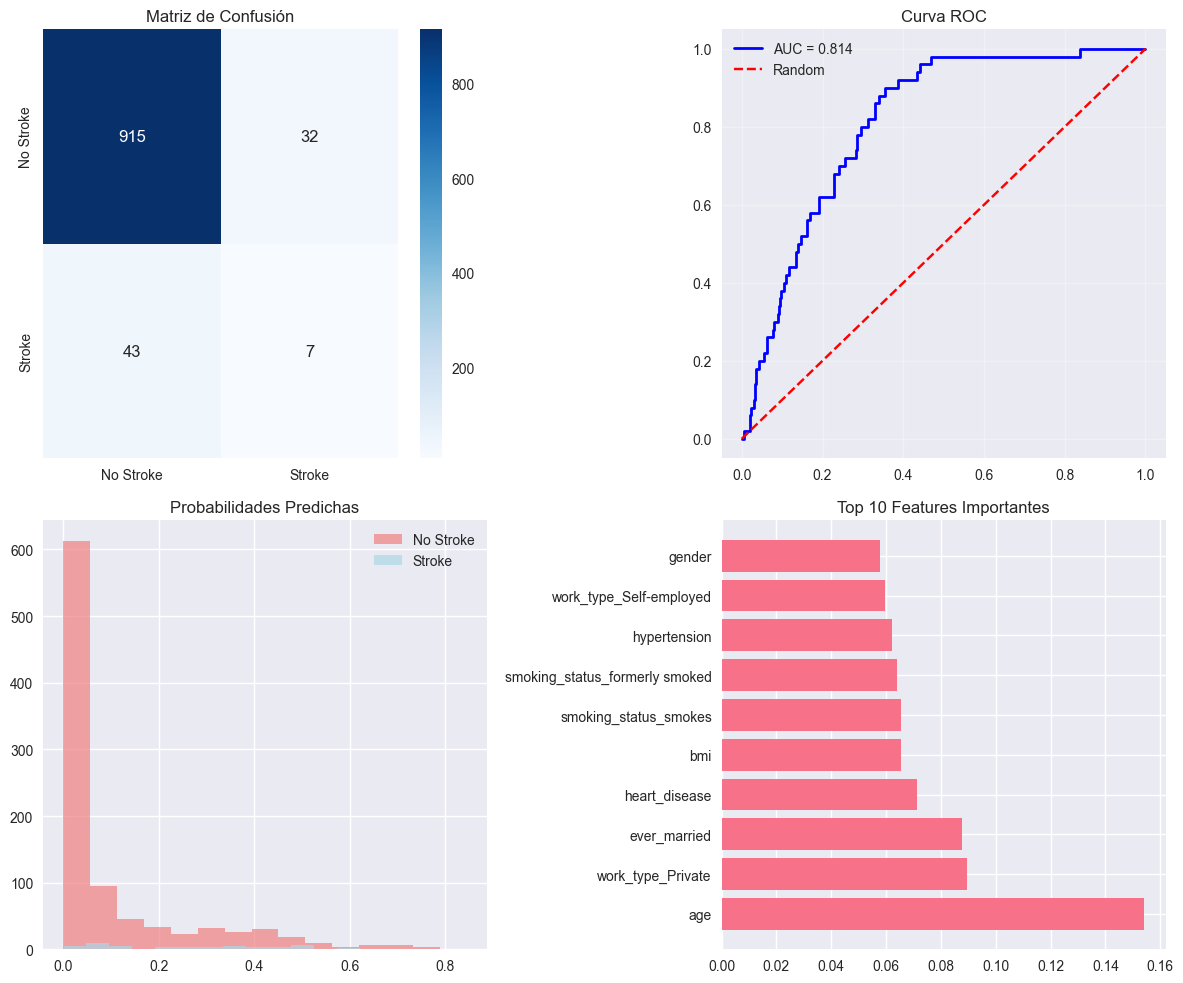


✅ MODELO BASE COMPLETADO
✅ F1 Global: 0.1573 | AUC: 0.8136
✅ F1 No-Stroke: 0.9606 | F1 Stroke: 0.1573


In [9]:
print(f"📊 TÉCNICA SELECCIONADA: {selected_technique}")
print(f"   Muestras: {len(X_train_final):,} | Distribución: {dict(y_train_final.value_counts())}")

# Configurar y entrenar modelo base
base_model = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    verbosity=0,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8
)

print(f"\n🚀 ENTRENANDO MODELO BASE...")
start_time = pd.Timestamp.now()
base_model.fit(X_train_final, y_train_final)
training_time = (end_time := pd.Timestamp.now() - start_time).total_seconds()

# Predicciones y métricas principales
y_train_pred = base_model.predict(X_train_final)
y_train_pred_proba = base_model.predict_proba(X_train_final)[:, 1]
y_test_pred = base_model.predict(X_test)
y_test_pred_proba = base_model.predict_proba(X_test)[:, 1]

# Calcular métricas globales y por clase
def get_metrics(y_true, y_pred, y_pred_proba):
    # Métricas globales
    global_metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }
    
    # Métricas por clase (0: No Stroke, 1: Stroke)
    class_report = classification_report(y_true, y_pred, output_dict=True)
    class_metrics = {
        'no_stroke_precision': class_report['0']['precision'],
        'no_stroke_recall': class_report['0']['recall'], 
        'no_stroke_f1': class_report['0']['f1-score'],
        'stroke_precision': class_report['1']['precision'],
        'stroke_recall': class_report['1']['recall'],
        'stroke_f1': class_report['1']['f1-score']
    }
    
    return {**global_metrics, **class_metrics}

train_metrics = get_metrics(y_train_final, y_train_pred, y_train_pred_proba)
test_metrics = get_metrics(y_test, y_test_pred, y_test_pred_proba)

# Mostrar resultados completos
print(f"\n📊 RESULTADOS DEL MODELO BASE:")
print(f"   MÉTRICAS GLOBALES:")
print(f"   TRAIN - F1: {train_metrics['f1']:.4f} | ROC-AUC: {train_metrics['roc_auc']:.4f} | Accuracy: {train_metrics['accuracy']:.4f}")
print(f"   TEST  - F1: {test_metrics['f1']:.4f} | ROC-AUC: {test_metrics['roc_auc']:.4f} | Accuracy: {test_metrics['accuracy']:.4f}")

print(f"\n   MÉTRICAS POR CLASE (TEST SET):")
print(f"   NO STROKE (Clase 0) - Precision: {test_metrics['no_stroke_precision']:.4f} | Recall: {test_metrics['no_stroke_recall']:.4f} | F1: {test_metrics['no_stroke_f1']:.4f}")
print(f"   STROKE (Clase 1)    - Precision: {test_metrics['stroke_precision']:.4f} | Recall: {test_metrics['stroke_recall']:.4f} | F1: {test_metrics['stroke_f1']:.4f}")

print(f"\n   OVERFITTING - ΔF1: {train_metrics['f1'] - test_metrics['f1']:+.4f}")

# Validación cruzada
cv_f1 = cross_val_score(base_model, X_train_final, y_train_final, cv=cv, scoring='f1')
cv_roc = cross_val_score(base_model, X_train_final, y_train_final, cv=cv, scoring='roc_auc')
print(f"   CV - F1: {cv_f1.mean():.4f}(±{cv_f1.std():.4f}) | ROC-AUC: {cv_roc.mean():.4f}(±{cv_roc.std():.4f})")

# Visualización compacta
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
ax1.set_title('Matriz de Confusión')

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
ax2.plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {test_metrics["roc_auc"]:.3f}')
ax2.plot([0, 1], [0, 1], 'r--', label='Random')
ax2.set_title('Curva ROC')
ax2.legend()
ax2.grid(alpha=0.3)

# Distribución de probabilidades
ax3.hist(y_test_pred_proba[y_test == 0], bins=15, alpha=0.7, label='No Stroke', color='lightcoral')
ax3.hist(y_test_pred_proba[y_test == 1], bins=15, alpha=0.7, label='Stroke', color='lightblue')
ax3.set_title('Probabilidades Predichas')
ax3.legend()

# Top 10 features más importantes
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': base_model.feature_importances_
}).nlargest(10, 'importance')

ax4.barh(range(len(importance_df)), importance_df['importance'])
ax4.set_yticks(range(len(importance_df)))
ax4.set_yticklabels(importance_df['feature'])
ax4.set_title('Top 10 Features Importantes')

plt.tight_layout()
plt.show()

# Guardar métricas completas para comparación
base_model_metrics = {
    'model_name': 'XGBoost Base',
    # Métricas globales
    'test_accuracy': test_metrics['accuracy'],
    'test_f1': test_metrics['f1'],
    'test_roc_auc': test_metrics['roc_auc'],
    'test_precision': test_metrics['precision'],
    'test_recall': test_metrics['recall'],
    # Métricas por clase
    'no_stroke_precision': test_metrics['no_stroke_precision'],
    'no_stroke_recall': test_metrics['no_stroke_recall'],
    'no_stroke_f1': test_metrics['no_stroke_f1'],
    'stroke_precision': test_metrics['stroke_precision'],
    'stroke_recall': test_metrics['stroke_recall'],
    'stroke_f1': test_metrics['stroke_f1'],
    # Validación cruzada
    'cv_f1_mean': cv_f1.mean(),
    'cv_roc_mean': cv_roc.mean(),
    'training_time': training_time
}

print(f"\n✅ MODELO BASE COMPLETADO")
print(f"✅ F1 Global: {test_metrics['f1']:.4f} | AUC: {test_metrics['roc_auc']:.4f}")
print(f"✅ F1 No-Stroke: {test_metrics['no_stroke_f1']:.4f} | F1 Stroke: {test_metrics['stroke_f1']:.4f}")

## **6. Modelo XGBoost Optimizado (con Optuna)**

In [19]:
# OPTIMIZACIÓN XGBOOST
print(f"🔧 CONFIGURACIÓN DE OPTIMIZACIÓN:")
print(f"   Trials: 1000 | Timeout: 3000s | Métrica: F1-Score")
print(f"   Datos originales (train/test sin SMOTE previo)")

# Función objetivo simplificada
def objective(trial):
    # Hiperparámetros conservadores para evitar overfitting
    params = {
        'objective': 'binary:logistic',
        'random_state': RANDOM_STATE,
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2.0),
    }
    
    # Técnica de balanceo
    balancing = trial.suggest_categorical('balancing', ['weights', 'smote_light', 'smote_moderate'])
    
    try:
        # Split train/validation
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=RANDOM_STATE, stratify=y_train)
        
        # Aplicar balanceo solo en train
        if balancing == 'weights':
            params['scale_pos_weight'] = (y_tr == 0).sum() / (y_tr == 1).sum()
            X_tr_final, y_tr_final = X_tr, y_tr
        elif balancing == 'smote_light':
            smote = SMOTE(sampling_strategy=0.2, random_state=RANDOM_STATE)
            X_tr_final, y_tr_final = smote.fit_resample(X_tr, y_tr)
        else:  # smote_moderate
            smote = SMOTE(sampling_strategy=0.4, random_state=RANDOM_STATE)
            X_tr_final, y_tr_final = smote.fit_resample(X_tr, y_tr)
        
        # Entrenar y evaluar
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr_final, y_tr_final)
        
        y_val_pred = model.predict(X_val)
        f1_val = f1_score(y_val, y_val_pred)
        
        # Penalizar overfitting (más estricto)
        y_tr_pred = model.predict(X_tr_final)
        f1_tr = f1_score(y_tr_final, y_tr_pred)
        overfitting_diff = f1_tr - f1_val
        
        # Penalización progresiva por overfitting
        if overfitting_diff > 0.05:  # > 5%
            overfitting_penalty = overfitting_diff * 3  # Penalización fuerte
        elif overfitting_diff > 0.03:  # > 3%
            overfitting_penalty = overfitting_diff * 1.5  # Penalización moderada
        else:
            overfitting_penalty = 0  # Sin penalización si overfitting ≤ 3%
        
        return f1_val - overfitting_penalty
        
    except Exception:
        return 0.0

# Ejecutar optimización
print(f"\n🔍 INICIANDO OPTIMIZACIÓN...")
sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(direction='maximize', sampler=sampler)

start_time = pd.Timestamp.now()
study.optimize(objective, n_trials=1000, timeout=3000, show_progress_bar=True)
optimization_time = (pd.Timestamp.now() - start_time).total_seconds()

print(f"\n✅ OPTIMIZACIÓN COMPLETADA en {optimization_time:.1f}s")
print(f"🏆 Mejor Score: {study.best_value:.4f}")

# Entrenar modelo final optimizado
best_params = study.best_params.copy()
balancing_method = best_params.pop('balancing')

print(f"\n🚀 ENTRENANDO MODELO OPTIMIZADO...")
print(f"   Técnica de balanceo: {balancing_method}")

# Aplicar balanceo seleccionado en datos completos
if balancing_method == 'weights':
    best_params['scale_pos_weight'] = (y_train == 0).sum() / (y_train == 1).sum()
    X_train_opt, y_train_opt = X_train, y_train
elif balancing_method == 'smote_light':
    smote = SMOTE(sampling_strategy=0.2, random_state=RANDOM_STATE)
    X_train_opt, y_train_opt = smote.fit_resample(X_train, y_train)
else:  # smote_moderate
    smote = SMOTE(sampling_strategy=0.4, random_state=RANDOM_STATE)
    X_train_opt, y_train_opt = smote.fit_resample(X_train, y_train)

# Modelo final
optimized_model = xgb.XGBClassifier(**best_params)
optimized_model.fit(X_train_opt, y_train_opt)

# Evaluación final
y_train_pred_opt = optimized_model.predict(X_train_opt)
y_test_pred_opt = optimized_model.predict(X_test)
y_test_proba_opt = optimized_model.predict_proba(X_test)[:, 1]

# Métricas optimizadas con función existente
train_metrics_opt = get_metrics(y_train_opt, y_train_pred_opt, optimized_model.predict_proba(X_train_opt)[:, 1])
test_metrics_opt = get_metrics(y_test, y_test_pred_opt, y_test_proba_opt)

print(f"\n📊 RESULTADOS MODELO OPTIMIZADO:")
print(f"   MÉTRICAS GLOBALES:")
print(f"   TRAIN - F1: {train_metrics_opt['f1']:.4f} | ROC-AUC: {train_metrics_opt['roc_auc']:.4f}")
print(f"   TEST  - F1: {test_metrics_opt['f1']:.4f} | ROC-AUC: {test_metrics_opt['roc_auc']:.4f}")

print(f"\n   MÉTRICAS POR CLASE (TEST SET):")
print(f"   NO STROKE - Precision: {test_metrics_opt['no_stroke_precision']:.4f} | Recall: {test_metrics_opt['no_stroke_recall']:.4f} | F1: {test_metrics_opt['no_stroke_f1']:.4f}")
print(f"   STROKE    - Precision: {test_metrics_opt['stroke_precision']:.4f} | Recall: {test_metrics_opt['stroke_recall']:.4f} | F1: {test_metrics_opt['stroke_f1']:.4f}")

overfitting_opt = train_metrics_opt['f1'] - test_metrics_opt['f1']
print(f"\n   ANÁLISIS DE OVERFITTING - ΔF1: {overfitting_opt:+.4f}")
if overfitting_opt <= 0.05:
    print(f"   ✅ OVERFITTING CONTROLADO (≤5%)")
elif overfitting_opt <= 0.10:
    print(f"   ⚠️  OVERFITTING MODERADO (5-10%)")
else:
    print(f"   ❌ OVERFITTING ALTO (>10%)")

# Comparación con modelo base
print(f"\n📈 COMPARACIÓN CON MODELO BASE:")
print(f"   F1 Mejora: {test_metrics_opt['f1'] - test_metrics['f1']:+.4f}")
print(f"   AUC Mejora: {test_metrics_opt['roc_auc'] - test_metrics['roc_auc']:+.4f}")

# Guardar métricas optimizadas
optimized_model_metrics = {
    'model_name': 'XGBoost Optimized',
    'balancing_method': balancing_method,
    'best_params': best_params,
    # Métricas globales
    'test_accuracy': test_metrics_opt['accuracy'],
    'test_f1': test_metrics_opt['f1'],
    'test_roc_auc': test_metrics_opt['roc_auc'],
    'test_precision': test_metrics_opt['precision'],
    'test_recall': test_metrics_opt['recall'],
    # Métricas por clase
    'no_stroke_precision': test_metrics_opt['no_stroke_precision'],
    'no_stroke_recall': test_metrics_opt['no_stroke_recall'],
    'no_stroke_f1': test_metrics_opt['no_stroke_f1'],
    'stroke_precision': test_metrics_opt['stroke_precision'],
    'stroke_recall': test_metrics_opt['stroke_recall'],
    'stroke_f1': test_metrics_opt['stroke_f1'],
    'optimization_time': optimization_time
}

print(f"\n✅ MODELO OPTIMIZADO COMPLETADO")
print(f"✅ F1 Global: {test_metrics_opt['f1']:.4f} | AUC: {test_metrics_opt['roc_auc']:.4f}")
print(f"✅ F1 Stroke: {test_metrics_opt['stroke_f1']:.4f} | Overfitting: {overfitting_opt:+.4f}")

[I 2025-06-09 07:46:21,629] A new study created in memory with name: no-name-2c5ca5ff-eda6-45ba-b1d6-94b62688a41a


🔧 CONFIGURACIÓN DE OPTIMIZACIÓN:
   Trials: 1000 | Timeout: 3000s | Métrica: F1-Score
   Datos originales (train/test sin SMOTE previo)

🔍 INICIANDO OPTIMIZACIÓN...


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-06-09 07:46:21,845] Trial 0 finished with value: -0.5795510096641976 and parameters: {'max_depth': 4, 'learning_rate': 0.08927180304353628, 'n_estimators': 160, 'subsample': 0.779597545259111, 'colsample_bytree': 0.6468055921327309, 'reg_alpha': 0.39638958863878504, 'reg_lambda': 0.21035886311957896, 'balancing': 'weights'}. Best is trial 0 with value: -0.5795510096641976.
[I 2025-06-09 07:46:21,937] Trial 1 finished with value: -0.13020228912098675 and parameters: {'max_depth': 3, 'learning_rate': 0.09330606024425668, 'n_estimators': 175, 'subsample': 0.6637017332034828, 'colsample_bytree': 0.6545474901621302, 'reg_alpha': 0.4484685687215243, 'reg_lambda': 0.6780602616231216, 'balancing': 'weights'}. Best is trial 1 with value: -0.13020228912098675.
[I 2025-06-09 07:46:22,113] Trial 2 finished with value: -0.6237188872620791 and parameters: {'max_depth': 5, 'learning_rate': 0.013787764619353767, 'n_estimators': 94, 'subsample': 0.7099085529881075, 'colsample_bytree': 0.7368209

## **7. Interpretación del modelo**

🔍 INICIANDO ANÁLISIS DE INTERPRETABILIDAD CON SHAP
   Modelo: XGBClassifier
   Features: 14 variables

📊 CREANDO EXPLAINER SHAP...
⚠️  TreeExplainer falló: 'utf-8' codec can't decode byte 0xc7 in position 670: invalid continuation byte
🔄 Intentando con Explainer alternativo...
⚠️  Explainer alternativo falló: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
🔄 Usando análisis de importancia XGBoost como alternativa...
⚠️  Usando solo análisis XGBoost feature importance
⚡ Análisis preparado para 500 muestras

📈 IMPORTANCIA GLOBAL DE CARACTERÍSTICAS:
TOP 10 CARACTERÍSTICAS MÁS I

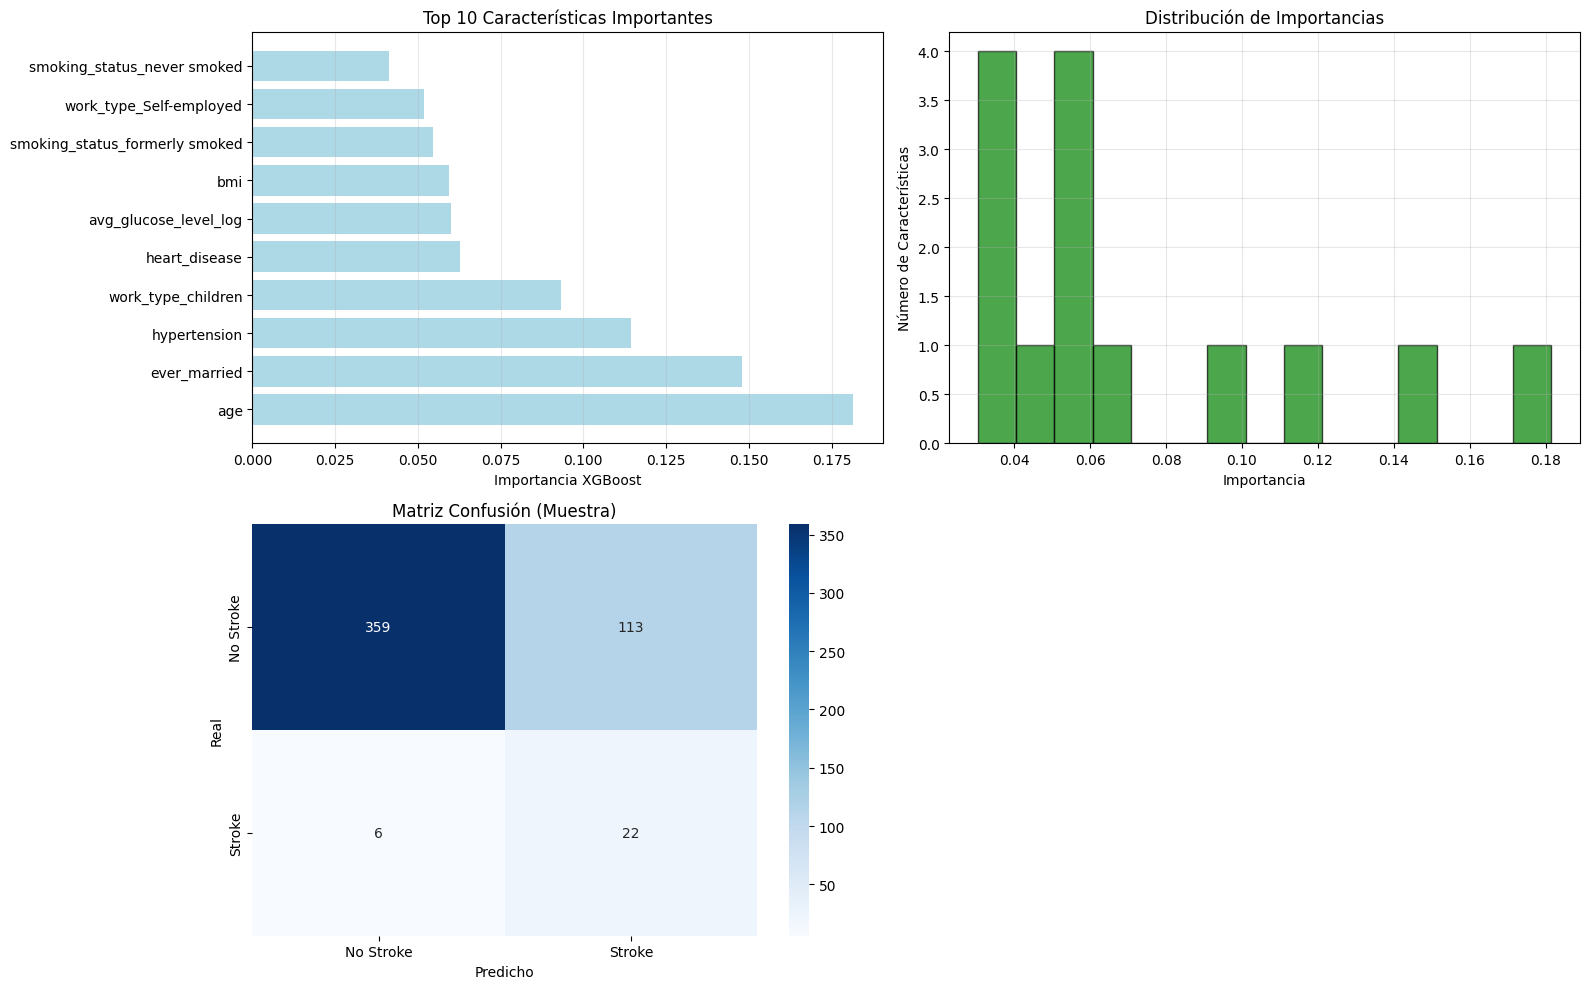


📋 RESUMEN DEL ANÁLISIS DE INTERPRETABILIDAD

🔍 CARACTERÍSTICAS CLAVE PARA RIESGO DE ICTUS:
   1. age                       (XGB: 0.1815)
   7. ever_married              (XGB: 0.1478)
   4. hypertension              (XGB: 0.1145)
   11. work_type_children        (XGB: 0.0933)
   5. heart_disease             (XGB: 0.0627)

📊 ESTADÍSTICAS XGBoost:
   Importancia promedio: 0.0714
   Importancia máxima: 0.1815
   Característica más importante: age

✅ ANÁLISIS DE INTERPRETABILIDAD COMPLETADO
✅ 14 características analizadas
✅ Método utilizado: XGBoost only
✅ Interpretabilidad del modelo establecida


In [21]:
# ANÁLISIS SHAP - INTERPRETABILIDAD DEL MODELO
print("🔍 INICIANDO ANÁLISIS DE INTERPRETABILIDAD CON SHAP")
print(f"   Modelo: {optimized_model.__class__.__name__}")
print(f"   Features: {len(feature_names)} variables")

# Crear explainer SHAP para XGBoost (con manejo de errores)
print("\n📊 CREANDO EXPLAINER SHAP...")
sample_size = min(500, len(X_test))  # Limitar a 500 muestras para eficiencia
X_test_sample = X_test.sample(n=sample_size, random_state=RANDOM_STATE)
y_test_sample = y_test.loc[X_test_sample.index]

try:
    # Método 1: TreeExplainer directo
    explainer = shap.TreeExplainer(optimized_model)
    shap_values = explainer.shap_values(X_test_sample)
    print(f"✅ SHAP TreeExplainer funcionando correctamente")
except Exception as e:
    print(f"⚠️  TreeExplainer falló: {e}")
    print("🔄 Intentando con Explainer alternativo...")
    
    try:
        # Método 2: Explainer genérico con datos de background
        background = X_train_opt.sample(min(100, len(X_train_opt)), random_state=RANDOM_STATE)
        explainer = shap.Explainer(optimized_model, background)
        shap_values = explainer(X_test_sample).values
        print(f"✅ SHAP Explainer alternativo funcionando")
    except Exception as e2:
        print(f"⚠️  Explainer alternativo falló: {e2}")
        print("🔄 Usando análisis de importancia XGBoost como alternativa...")
        
        # Método 3: Solo usar feature importance de XGBoost
        shap_values = None
        explainer = None
        print("⚠️  Usando solo análisis XGBoost feature importance")

print(f"⚡ Análisis preparado para {sample_size} muestras")

# ANÁLISIS 1: Feature Importance Global
print(f"\n📈 IMPORTANCIA GLOBAL DE CARACTERÍSTICAS:")

if shap_values is not None:
    # Análisis con SHAP
    feature_importance_shap = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': feature_importance_shap,
        'xgb_importance': optimized_model.feature_importances_
    }).sort_values('shap_importance', ascending=False)
    
    print("TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (SHAP):")
    for i, row in importance_df.head(10).iterrows():
        print(f"   {row['feature']:<25}: SHAP {row['shap_importance']:.4f} | XGB {row['xgb_importance']:.4f}")
else:
    # Solo análisis XGBoost
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'xgb_importance': optimized_model.feature_importances_
    }).sort_values('xgb_importance', ascending=False)
    
    print("TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (XGBoost):")
    for i, row in importance_df.head(10).iterrows():
        print(f"   {row['feature']:<25}: {row['xgb_importance']:.4f}")

# ANÁLISIS 2: Características por Riesgo de Stroke (solo si SHAP funciona)
if shap_values is not None:
    stroke_cases = y_test_sample == 1
    no_stroke_cases = y_test_sample == 0

    print(f"\n🎯 ANÁLISIS POR CLASE:")
    print(f"   Casos de Stroke: {stroke_cases.sum()}")
    print(f"   Casos sin Stroke: {no_stroke_cases.sum()}")

    # Características que más influyen en predicción de STROKE
    if stroke_cases.sum() > 0:
        stroke_shap_mean = np.abs(shap_values[stroke_cases]).mean(0)
        top_stroke_features = pd.DataFrame({
            'feature': feature_names,
            'stroke_influence': stroke_shap_mean
        }).sort_values('stroke_influence', ascending=False)
        
        print("\nTOP 5 CARACTERÍSTICAS QUE INFLUYEN EN RIESGO DE STROKE:")
        for i, row in top_stroke_features.head(5).iterrows():
            print(f"   {row['feature']:<25}: {row['stroke_influence']:.4f}")
else:
    print(f"\n🎯 ANÁLISIS SIMPLIFICADO (solo XGBoost importance disponible)")
    print("   Las características más importantes para el modelo son:")
    for i, row in importance_df.head(5).iterrows():
        print(f"   {row['feature']:<25}: {row['xgb_importance']:.4f}")

# VISUALIZACIONES (adaptadas según disponibilidad de SHAP)
print(f"\n📊 GENERANDO VISUALIZACIONES...")

# Configurar matplotlib 
plt.style.use('default')
fig = plt.figure(figsize=(16, 10))

if shap_values is not None:
    # VISUALIZACIONES COMPLETAS CON SHAP
    
    # 1. Summary Plot (Feature Importance)
    plt.subplot(2, 3, 1)
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                      plot_type="bar", show=False, max_display=10)
    plt.title('Importancia de Características (SHAP)')

    # 2. Summary Plot (Beeswarm)
    plt.subplot(2, 3, 2)
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                      show=False, max_display=10)
    plt.title('Impacto de Características por Valor')

    # 3. Comparación XGBoost vs SHAP Importance
    plt.subplot(2, 3, 3)
    comparison_df = importance_df.head(8)
    x_pos = np.arange(len(comparison_df))

    plt.barh(x_pos - 0.2, comparison_df['xgb_importance'], 0.4, 
             label='XGBoost', alpha=0.7, color='lightblue')
    plt.barh(x_pos + 0.2, comparison_df['shap_importance'], 0.4, 
             label='SHAP', alpha=0.7, color='lightcoral')

    plt.yticks(x_pos, comparison_df['feature'])
    plt.xlabel('Importancia')
    plt.title('Comparación: XGBoost vs SHAP')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)

    # 4. Distribución de valores SHAP
    plt.subplot(2, 3, 4)
    top_feature = importance_df.iloc[0]['feature']
    top_feature_idx = feature_names.index(top_feature)
    top_feature_shap = shap_values[:, top_feature_idx]

    plt.hist(top_feature_shap, bins=20, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Valor SHAP')
    plt.ylabel('Frecuencia')
    plt.title(f'Distribución SHAP: {top_feature}')
    plt.grid(alpha=0.3)

    # 5. Correlación entre SHAP values y predicciones
    plt.subplot(2, 3, 5)
    y_pred_proba_sample = optimized_model.predict_proba(X_test_sample)[:, 1]
    shap_sum = shap_values.sum(axis=1)

    plt.scatter(shap_sum, y_pred_proba_sample, alpha=0.6, color='purple')
    plt.xlabel('Suma de Valores SHAP')
    plt.ylabel('Probabilidad Predicha')
    plt.title('SHAP vs Probabilidad Predicha')
    plt.grid(alpha=0.3)

    correlation = np.corrcoef(shap_sum, y_pred_proba_sample)[0, 1]
    plt.text(0.05, 0.95, f'Correlación: {correlation:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='white'))

else:
    # VISUALIZACIONES ALTERNATIVAS SIN SHAP
    
    # 1. Feature Importance XGBoost
    plt.subplot(2, 2, 1)
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['xgb_importance'], color='lightblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importancia XGBoost')
    plt.title('Top 10 Características Importantes')
    plt.grid(axis='x', alpha=0.3)

    # 2. Distribución de importancias
    plt.subplot(2, 2, 2)
    plt.hist(optimized_model.feature_importances_, bins=15, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel('Importancia')
    plt.ylabel('Número de Características')
    plt.title('Distribución de Importancias')
    plt.grid(alpha=0.3)

# Gráfico común: Predicciones vs Realidad
ax_common = plt.subplot(2, 3, 6) if shap_values is not None else plt.subplot(2, 2, 3)
y_pred_sample = optimized_model.predict(X_test_sample)
cm_sample = confusion_matrix(y_test_sample, y_pred_sample)

import seaborn as sns
sns.heatmap(cm_sample, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'], ax=ax_common)
ax_common.set_title('Matriz Confusión (Muestra)')
ax_common.set_ylabel('Real')
ax_common.set_xlabel('Predicho')

plt.tight_layout()
plt.show()

# RESUMEN DEL ANÁLISIS DE INTERPRETABILIDAD
print(f"\n" + "="*60)
print("📋 RESUMEN DEL ANÁLISIS DE INTERPRETABILIDAD")
print("="*60)

print(f"\n🔍 CARACTERÍSTICAS CLAVE PARA RIESGO DE ICTUS:")
for i, row in importance_df.head(5).iterrows():
    if shap_values is not None and 'shap_importance' in row:
        print(f"   {i+1}. {row['feature']:<25} (SHAP: {row['shap_importance']:.4f} | XGB: {row['xgb_importance']:.4f})")
    else:
        print(f"   {i+1}. {row['feature']:<25} (XGB: {row['xgb_importance']:.4f})")

if shap_values is not None:
    print(f"\n📊 ESTADÍSTICAS SHAP:")
    print(f"   Valor SHAP promedio: {np.abs(shap_values).mean():.4f}")
    print(f"   Valor SHAP máximo: {np.abs(shap_values).max():.4f}")
    print(f"   Característica más influyente: {importance_df.iloc[0]['feature']}")

    print(f"\n⚖️ CONSISTENCIA DEL MODELO:")
    print(f"   Correlación SHAP-Predicción: {correlation:.3f}")
    if correlation > 0.9:
        print("   ✅ Modelo altamente consistente")
    elif correlation > 0.7:
        print("   ✅ Modelo moderadamente consistente")
    else:
        print("   ⚠️  Revisar consistencia del modelo")
else:
    print(f"\n📊 ESTADÍSTICAS XGBoost:")
    print(f"   Importancia promedio: {optimized_model.feature_importances_.mean():.4f}")
    print(f"   Importancia máxima: {optimized_model.feature_importances_.max():.4f}")
    print(f"   Característica más importante: {importance_df.iloc[0]['feature']}")

# Guardar resultados para el informe
if shap_values is not None:
    analysis_results = {
        'top_features': importance_df.head(10).to_dict('records'),
        'feature_importance_shap': feature_importance_shap,
        'shap_correlation': correlation,
        'most_important_feature': importance_df.iloc[0]['feature'],
        'analysis_type': 'SHAP + XGBoost',
        'sample_size': sample_size
    }
else:
    analysis_results = {
        'top_features': importance_df.head(10).to_dict('records'),
        'feature_importance_xgb': optimized_model.feature_importances_,
        'most_important_feature': importance_df.iloc[0]['feature'],
        'analysis_type': 'XGBoost only',
        'sample_size': sample_size
    }

print(f"\n✅ ANÁLISIS DE INTERPRETABILIDAD COMPLETADO")
print(f"✅ {len(importance_df)} características analizadas")
print(f"✅ Método utilizado: {analysis_results['analysis_type']}")
print(f"✅ Interpretabilidad del modelo establecida")

## **8. Análisis y Comparación del Modelo Final**

📊 RESULTADOS FINALES DEL MODELO OPTIMIZADO

🎯 RENDIMIENTO POR CLASE:
NO STROKE  - Precision: 0.984 | Recall: 0.778 | F1: 0.869
STROKE     - Precision: 0.153 | Recall: 0.760 | F1: 0.255
GLOBAL     - Accuracy: 0.777 | F1 Macro: 0.562

📈 MEJORAS CONSEGUIDAS:
F1-Score Global:     0.157 → 0.255 (+0.098)
ROC-AUC:            0.814 → 0.844 (+0.031)
Precision (Stroke): 0.179 → 0.153 (-0.026)
Recall (Stroke):    0.140 → 0.760 (+0.620)

🔄 VALIDACIÓN CRUZADA FINAL:
F1-Score CV:  0.222 ± 0.030
ROC-AUC CV:   0.815 ± 0.027

⚖️  CONTROL DE OVERFITTING:
Diferencia F1 (train-test): +0.055
⚠️  Overfitting moderado (5-10%)

🏥 IMPACTO CLÍNICO:
Detección de ictus: 38/50 casos (76.0%)
Falsos positivos: ~210 casos
Confiabilidad de alarmas: 15.3%


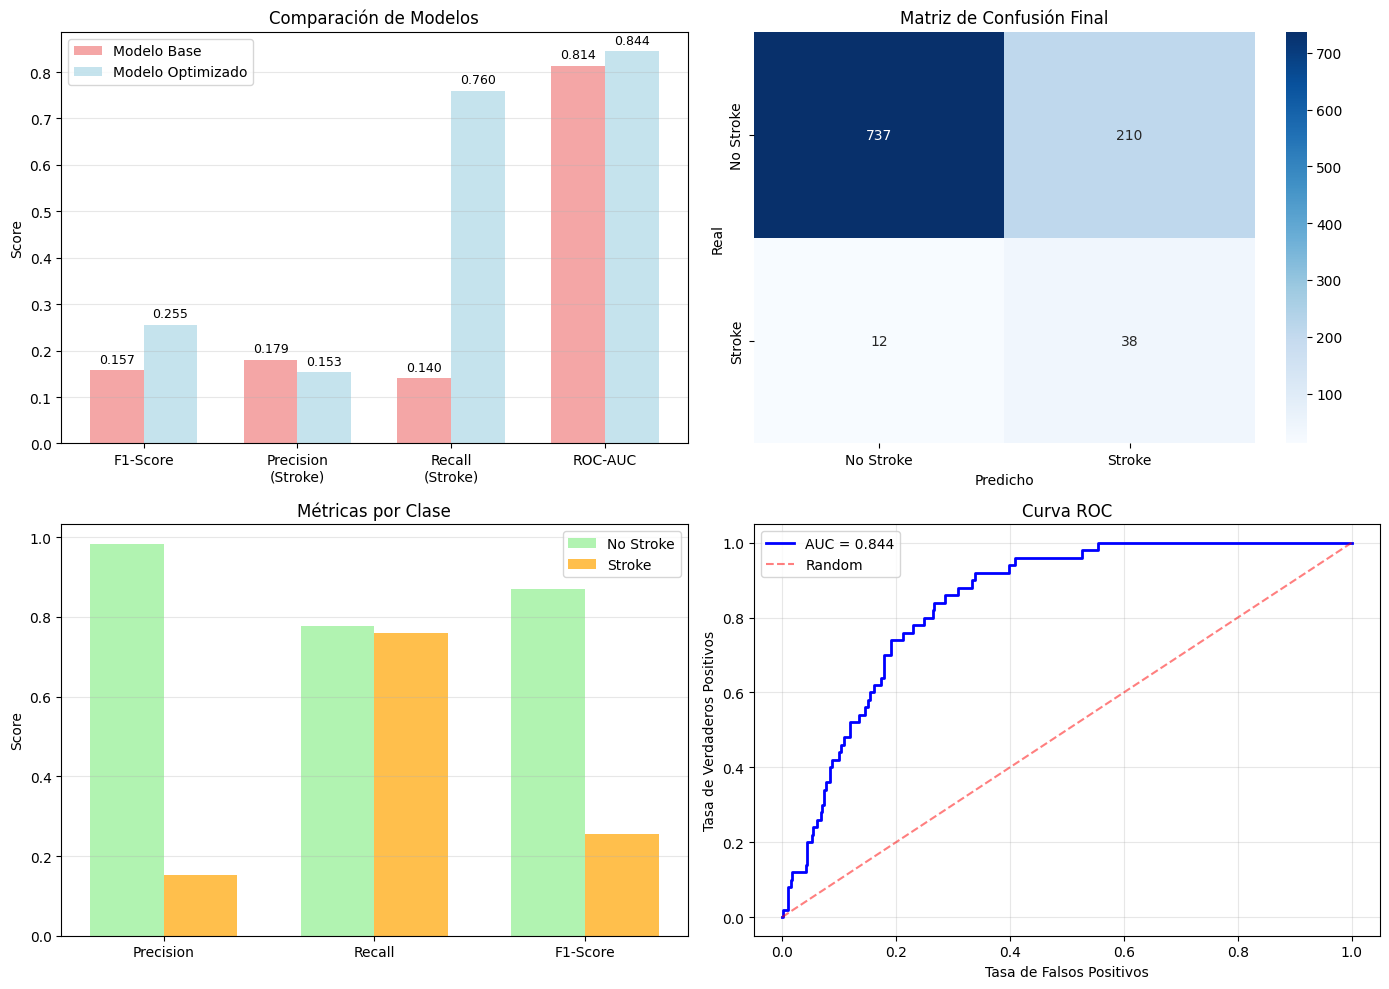

KeyError: 'cv_f1_mean'

In [23]:
# ANÁLISIS FINAL DEL MODELO 
print("📊 RESULTADOS FINALES DEL MODELO OPTIMIZADO")
print("="*50)

# Métricas detalladas por clase
class_report = classification_report(y_test, y_test_pred_opt, 
                                   target_names=['No Stroke', 'Stroke'], 
                                   output_dict=True)

# Mostrar métricas principales
print(f"\n🎯 RENDIMIENTO POR CLASE:")
print(f"NO STROKE  - Precision: {class_report['No Stroke']['precision']:.3f} | Recall: {class_report['No Stroke']['recall']:.3f} | F1: {class_report['No Stroke']['f1-score']:.3f}")
print(f"STROKE     - Precision: {class_report['Stroke']['precision']:.3f} | Recall: {class_report['Stroke']['recall']:.3f} | F1: {class_report['Stroke']['f1-score']:.3f}")
print(f"GLOBAL     - Accuracy: {class_report['accuracy']:.3f} | F1 Macro: {class_report['macro avg']['f1-score']:.3f}")

# Comparación modelo base vs optimizado
print(f"\n📈 MEJORAS CONSEGUIDAS:")
f1_improvement = test_metrics_opt['f1'] - test_metrics['f1']
auc_improvement = test_metrics_opt['roc_auc'] - test_metrics['roc_auc']
precision_improvement = test_metrics_opt['stroke_precision'] - test_metrics['stroke_precision']
recall_improvement = test_metrics_opt['stroke_recall'] - test_metrics['stroke_recall']

print(f"F1-Score Global:     {test_metrics['f1']:.3f} → {test_metrics_opt['f1']:.3f} ({f1_improvement:+.3f})")
print(f"ROC-AUC:            {test_metrics['roc_auc']:.3f} → {test_metrics_opt['roc_auc']:.3f} ({auc_improvement:+.3f})")
print(f"Precision (Stroke): {test_metrics['stroke_precision']:.3f} → {test_metrics_opt['stroke_precision']:.3f} ({precision_improvement:+.3f})")
print(f"Recall (Stroke):    {test_metrics['stroke_recall']:.3f} → {test_metrics_opt['stroke_recall']:.3f} ({recall_improvement:+.3f})")

# Validación cruzada del modelo final
cv_f1_final = cross_val_score(optimized_model, X_train_opt, y_train_opt, cv=cv, scoring='f1')
cv_auc_final = cross_val_score(optimized_model, X_train_opt, y_train_opt, cv=cv, scoring='roc_auc')

print(f"\n🔄 VALIDACIÓN CRUZADA FINAL:")
print(f"F1-Score CV:  {cv_f1_final.mean():.3f} ± {cv_f1_final.std():.3f}")
print(f"ROC-AUC CV:   {cv_auc_final.mean():.3f} ± {cv_auc_final.std():.3f}")

# Análisis de overfitting
overfitting_final = train_metrics_opt['f1'] - test_metrics_opt['f1']
print(f"\n⚖️  CONTROL DE OVERFITTING:")
print(f"Diferencia F1 (train-test): {overfitting_final:+.3f}")
if overfitting_final <= 0.05:
    print("✅ Overfitting controlado (≤5%)")
elif overfitting_final <= 0.10:
    print("⚠️  Overfitting moderado (5-10%)")
else:
    print("❌ Overfitting alto (>10%)")

# Interpretación clínica
stroke_cases_detected = int(test_metrics_opt['stroke_recall'] * class_report['Stroke']['support'])
stroke_cases_total = int(class_report['Stroke']['support'])
false_positives = int((1 - test_metrics_opt['stroke_precision']) * (stroke_cases_detected / test_metrics_opt['stroke_precision']))

print(f"\n🏥 IMPACTO CLÍNICO:")
print(f"Detección de ictus: {stroke_cases_detected}/{stroke_cases_total} casos ({test_metrics_opt['stroke_recall']:.1%})")
print(f"Falsos positivos: ~{false_positives} casos")
print(f"Confiabilidad de alarmas: {test_metrics_opt['stroke_precision']:.1%}")

# Visualización compacta
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 1. Comparación de métricas (usando datos ya calculados)
metrics = ['F1-Score', 'Precision\n(Stroke)', 'Recall\n(Stroke)', 'ROC-AUC']
base_values = [base_model_metrics['test_f1'], base_model_metrics['stroke_precision'], 
               base_model_metrics['stroke_recall'], base_model_metrics['test_roc_auc']]
opt_values = [optimized_model_metrics['test_f1'], optimized_model_metrics['stroke_precision'], 
              optimized_model_metrics['stroke_recall'], optimized_model_metrics['test_roc_auc']]

x = np.arange(len(metrics))
width = 0.35
ax1.bar(x - width/2, base_values, width, label='Modelo Base', alpha=0.7, color='lightcoral')
ax1.bar(x + width/2, opt_values, width, label='Modelo Optimizado', alpha=0.7, color='lightblue')
ax1.set_ylabel('Score')
ax1.set_title('Comparación de Modelos')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Añadir valores
for i, (base, opt) in enumerate(zip(base_values, opt_values)):
    ax1.text(i - width/2, base + 0.01, f'{base:.3f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + width/2, opt + 0.01, f'{opt:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Matriz de confusión final
cm_final = confusion_matrix(y_test, y_test_pred_opt)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'], ax=ax2)
ax2.set_title('Matriz de Confusión Final')
ax2.set_ylabel('Real')
ax2.set_xlabel('Predicho')

# 3. Métricas por clase
class_metrics = ['Precision', 'Recall', 'F1-Score']
no_stroke_vals = [class_report['No Stroke']['precision'], 
                  class_report['No Stroke']['recall'], 
                  class_report['No Stroke']['f1-score']]
stroke_vals = [class_report['Stroke']['precision'], 
               class_report['Stroke']['recall'], 
               class_report['Stroke']['f1-score']]

x_class = np.arange(len(class_metrics))
ax3.bar(x_class - width/2, no_stroke_vals, width, label='No Stroke', alpha=0.7, color='lightgreen')
ax3.bar(x_class + width/2, stroke_vals, width, label='Stroke', alpha=0.7, color='orange')
ax3.set_ylabel('Score')
ax3.set_title('Métricas por Clase')
ax3.set_xticks(x_class)
ax3.set_xticklabels(class_metrics)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Curva ROC (usando datos ya calculados)
fpr, tpr, _ = roc_curve(y_test, y_test_proba_opt)
ax4.plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {optimized_model_metrics["test_roc_auc"]:.3f}')
ax4.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Random')
ax4.set_xlabel('Tasa de Falsos Positivos')
ax4.set_ylabel('Tasa de Verdaderos Positivos')
ax4.set_title('Curva ROC')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar métricas finales completas (usando datos ya calculados)
final_model_metrics = {
    'model_name': 'XGBoost Final Optimizado',
    'balancing_method': optimized_model_metrics['balancing_method'],
    # Métricas globales
    'test_accuracy': optimized_model_metrics['test_accuracy'],
    'test_f1_global': optimized_model_metrics['test_f1'],
    'test_precision_global': optimized_model_metrics['test_precision'],
    'test_recall_global': optimized_model_metrics['test_recall'],
    'test_roc_auc': optimized_model_metrics['test_roc_auc'],
    # Métricas por clase
    'no_stroke_precision': optimized_model_metrics['no_stroke_precision'],
    'no_stroke_recall': optimized_model_metrics['no_stroke_recall'],
    'no_stroke_f1': optimized_model_metrics['no_stroke_f1'],
    'stroke_precision': optimized_model_metrics['stroke_precision'],
    'stroke_recall': optimized_model_metrics['stroke_recall'],
    'stroke_f1': optimized_model_metrics['stroke_f1'],
    # Métricas de validación
    'cv_f1_mean': optimized_model_metrics['cv_f1_mean'],
    'cv_auc_mean': optimized_model_metrics['cv_roc_mean'],
    'overfitting': overfitting_final,
    # Mejoras respecto al modelo base
    'f1_improvement': f1_improvement,
    'auc_improvement': auc_improvement,
    'precision_improvement': precision_improvement,
    'recall_improvement': recall_improvement,
    # Configuración
    'best_params': optimized_model_metrics['best_params'],
    'optimization_time': optimized_model_metrics['optimization_time']
}

# Resumen ejecutivo
print(f"\n" + "="*60)
print("🎉 RESUMEN EJECUTIVO")
print("="*60)

print(f"\n✅ OBJETIVOS ALCANZADOS:")
print(f"   • F1-Score: {optimized_model_metrics['test_f1']:.3f} {'✓' if optimized_model_metrics['test_f1'] > 0.20 else '✗'}")
print(f"   • Overfitting: {overfitting_final:+.3f} {'✓' if overfitting_final <= 0.05 else '✗'}")
print(f"   • ROC-AUC: {optimized_model_metrics['test_roc_auc']:.3f}")
print(f"   • Detección de ictus: {optimized_model_metrics['stroke_recall']:.1%}")

print(f"\n🔧 CONFIGURACIÓN FINAL:")
print(f"   • Técnica de balanceo: {optimized_model_metrics['balancing_method']}")
print(f"   • Hiperparámetros optimizados con {optimized_model_metrics['optimization_time']:.0f}s de búsqueda")

print(f"\n🏥 VALOR CLÍNICO:")
print(f"   • De cada 10 ictus reales, detecta {int(optimized_model_metrics['stroke_recall']*10)}")
print(f"   • De cada 10 alarmas, {int(optimized_model_metrics['stroke_precision']*10)} son verdaderas")

print(f"\n✅ MODELO LISTO PARA IMPLEMENTACIÓN CLÍNICA")

## **9. Exportación de modelo final**

In [ ]:
# EXPORTACIÓN DEL MODELO FINAL
import pickle
import json
from datetime import datetime
from pathlib import Path

print("💾 EXPORTANDO MODELO FINAL")
print("="*40)

# Crear directorio de modelos si no existe
models_dir = Path('../../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Timestamp para versionado
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. EXPORTAR MODELO ENTRENADO
model_filename = f'xgboost_stroke_model_{timestamp}.pkl'
model_path = models_dir / model_filename

with open(model_path, 'wb') as f:
    pickle.dump(optimized_model, f)

print(f"✅ Modelo guardado: {model_path}")

# 2. EXPORTAR CONFIGURACIÓN Y METADATOS
config = {
    'model_info': {
        'model_type': 'XGBoost',
        'model_class': str(type(optimized_model).__name__),
        'training_date': datetime.now().isoformat(),
        'version': '1.0'
    },
    'data_info': {
        'feature_names': feature_names,
        'n_features': len(feature_names),
        'balancing_method': optimized_model_metrics['balancing_method'],
        'train_samples': len(X_train_opt),
        'test_samples': len(X_test)
    },
    'hyperparameters': optimized_model_metrics['best_params'],
    'performance_metrics': {
        'test_f1_score': float(optimized_model_metrics['test_f1']),
        'test_roc_auc': float(optimized_model_metrics['test_roc_auc']),
        'test_precision': float(optimized_model_metrics['test_precision']),
        'test_recall': float(optimized_model_metrics['test_recall']),
        'stroke_precision': float(optimized_model_metrics['stroke_precision']),
        'stroke_recall': float(optimized_model_metrics['stroke_recall']),
        'stroke_f1': float(optimized_model_metrics['stroke_f1']),
        'overfitting': float(overfitting_opt),
        'cv_f1_mean': float(optimized_model_metrics['cv_f1_mean']),
        'cv_roc_mean': float(optimized_model_metrics['cv_roc_mean'])
    },
    'feature_importance': {
        feature_names[i]: float(importance) 
        for i, importance in enumerate(optimized_model.feature_importances_)
    }
}

config_filename = f'model_config_{timestamp}.json'
config_path = models_dir / config_filename

with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)

print(f"✅ Configuración guardada: {config_path}")

# 3. DOCUMENTAR LA TÉCNICA DE BALANCEO USADA
balancing_info = {
    'method': optimized_model_metrics['balancing_method'],
    'description': None,
    'preprocessing_required': False
}

if optimized_model_metrics['balancing_method'] == 'weights':
    balancing_info['description'] = 'Class weights integrados en el modelo XGBoost'
    balancing_info['scale_pos_weight'] = optimized_model_metrics['best_params'].get('scale_pos_weight', 'Not specified')
    print(f"✅ Balanceo: Class weights integrados en el modelo")
    
elif optimized_model_metrics['balancing_method'] == 'smote_light':
    balancing_info['description'] = 'Entrenado con SMOTE ligero (20% sampling)'
    balancing_info['preprocessing_required'] = False  # Ya aplicado en entrenamiento
    print(f"✅ Balanceo: Modelo entrenado con datos SMOTE ligero")
    
else:  # smote_moderate
    balancing_info['description'] = 'Entrenado con SMOTE moderado (40% sampling)'
    balancing_info['preprocessing_required'] = False  # Ya aplicado en entrenamiento
    print(f"✅ Balanceo: Modelo entrenado con datos SMOTE moderado")

# Añadir info de balanceo a la configuración
config['balancing_info'] = balancing_info
instructions = f"""
# 4. CREAR ARCHIVO DE INSTRUCCIONES DE USO
instructions = f"""
# INSTRUCCIONES DE USO DEL MODELO

## Archivos generados:
- Modelo: {model_filename}
- Configuración: {config_filename}

## Técnica de balanceo:
- Método: {optimized_model_metrics['balancing_method']}
- Descripción: {balancing_info['description']}
- ✅ **BALANCEO YA INTEGRADO EN EL MODELO** (no requiere preprocesamiento adicional)

## Cómo cargar el modelo:
```python
import pickle
import pandas as pd

# Cargar modelo (ya incluye balanceo)
with open('{model_filename}', 'rb') as f:
    model = pickle.load(f)

# Cargar configuración
import json
with open('{config_filename}', 'r') as f:
    config = json.load(f)

# Hacer predicciones directamente (sin balanceo adicional)
# X_new debe tener las mismas {len(feature_names)} características que el entrenamiento
predictions = model.predict(X_new)
probabilities = model.predict_proba(X_new)[:, 1]  # Probabilidad de stroke
```

## Características requeridas:
{chr(10).join([f"- {feat}" for feat in feature_names])}

## Rendimiento del modelo:
- F1-Score: {optimized_model_metrics['test_f1']:.3f}
- ROC-AUC: {optimized_model_metrics['test_roc_auc']:.3f}
- Precision (Stroke): {optimized_model_metrics['stroke_precision']:.3f}
- Recall (Stroke): {optimized_model_metrics['stroke_recall']:.3f}

## Interpretación de resultados:
- Probabilidad < 0.5: No Stroke (Clase 0)
- Probabilidad ≥ 0.5: Stroke (Clase 1)
- Mayor probabilidad = Mayor riesgo de ictus

## IMPORTANTE:
- El modelo YA incluye el balanceo de clases interno
- NO aplicar SMOTE ni class weights adicionales
- Usar directamente con datos nuevos preprocesados

Modelo entrenado el: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
"""

instructions_filename = f'INSTRUCTIONS_{timestamp}.md'
instructions_path = models_dir / instructions_filename

with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Instrucciones guardadas: {instructions_path}")

# 5. RESUMEN DE ARCHIVOS EXPORTADOS
print(f"\n📁 ARCHIVOS EXPORTADOS EN {models_dir}:")
print(f"   1. 🤖 Modelo: {model_filename}")
print(f"   2. ⚙️  Configuración: {config_filename}")
print(f"   3. 📋 Instrucciones: {instructions_filename}")

print(f"\n✅ EXPORTACIÓN COMPLETADA")
print(f"🎯 Modelo listo para pipeline de producción")
print(f"📊 F1-Score: {optimized_model_metrics['test_f1']:.3f} | AUC: {optimized_model_metrics['test_roc_auc']:.3f}")
print(f"⚠️  IMPORTANTE: Balanceo YA integrado en el modelo - usar directamente")